In [25]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [26]:
from bellem.dvc.experiment import load_experiments

filenames = [
    "temperature-sweep-1.json",
    "temperature-sweep-2.json",
    "temperature-sweep-3.json",
]

experiments = [exp for filename in filenames for exp in load_experiments(filename)]
print(f"{len(experiments)} experiments")
experiments[0]

525 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'no-role.txt',
   'user_prompt_template': 'cq.txt',
   'few_shot_examples': 'empty.json'},
  'run': 1},
 'metrics': {}}

In [27]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])
df = df[df["params.dataset.path"] == "bdsaglam/musique"].copy()
df.drop(columns=[col for col in df.columns if 'fuzzy' in col], inplace=True)

param_cols = [
    "params.dataset.path",
    "params.dataset.name",
    "params.dataset.split",
    "params.qa.model",
    "params.qa.temperature",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.run",
]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.dropna(subset=param_cols + metric_cols, inplace=True, how="any")
df.drop_duplicates(subset=param_cols, inplace=True)

In [28]:
def parse_qa_technique(system_prompt_filename):
    if "cte" in system_prompt_filename:
        return "CTE"
    if "cot" in system_prompt_filename:
        return "COT"
    return "Standard"

df["params.qa.technique"] = df["params.qa.system_prompt"].map(parse_qa_technique)

In [29]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [30]:
df['params.qa.n_shot'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [31]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,1,0.407944,0.489914,0.533546,0.625827,0.311842,0.377059,0.200000,0.281535,COT,0
1,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,2,0.407116,0.492792,0.527955,0.625286,0.310526,0.382631,0.214815,0.289931,COT,0
2,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.0,cot/excellent-format-reasoning.txt,cq.txt,empty.json,3,0.401738,0.489893,0.530351,0.627570,0.301316,0.377814,0.192593,0.274604,COT,0
3,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning.txt,cq.txt,empty.json,1,0.409599,0.493538,0.535144,0.630265,0.306579,0.378292,0.214815,0.287126,COT,0
4,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0.1,cot/excellent-format-reasoning.txt,cq.txt,empty.json,2,0.405048,0.490532,0.531949,0.629372,0.307895,0.374431,0.195062,0.279196,COT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal.txt,cq.txt,empty.json,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Standard,0
295,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,1.5,standard/minimal.txt,cq.txt,empty.json,3,0.000414,0.000532,0.000799,0.001027,0.000000,0.000000,0.000000,0.000000,Standard,0
296,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal.txt,cq.txt,empty.json,1,0.000000,0.000241,0.000000,0.000465,0.000000,0.000000,0.000000,0.000000,Standard,0
297,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal.txt,cq.txt,empty.json,2,0.000000,0.000033,0.000000,0.000064,0.000000,0.000000,0.000000,0.000000,Standard,0


In [32]:
df['params.qa.system_prompt'].unique().tolist()

['cot/excellent-format-reasoning.txt',
 'cot/format-minimal.txt',
 'cot/format-reasoning.txt',
 'cot/format-think.txt',
 'cte/excellent-format-few.txt',
 'cte/excellent-format-fewest.txt',
 'cte/format-few.txt',
 'cte/format-relevant-few.txt',
 'standard/excellent-few.txt',
 'standard/excellent-fewest.txt',
 'standard/helpful-output-format-few.txt',
 'standard/minimal-output-format-few-no-prio.txt',
 'standard/minimal-output-format-few.txt',
 'standard/minimal-output-format-fewest.txt',
 'standard/minimal-output-format.txt',
 'standard/minimal.txt']

In [33]:
def parse_system_prompt(system_prompt_filename):
    return system_prompt_filename.replace(".txt", "")

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(parse_system_prompt)

In [34]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run
35,cte/format-relevant-few,cq.txt,empty.json,0.0,"(1, 2)"


In [35]:
df.to_json('temperature-sweep.jsonl', orient='records', lines=True)

In [36]:
df.columns.to_list()

['params.dataset.path',
 'params.dataset.name',
 'params.dataset.split',
 'params.qa.model',
 'params.qa.temperature',
 'params.qa.system_prompt',
 'params.qa.user_prompt_template',
 'params.qa.few_shot_examples',
 'params.run',
 'metrics.exact_match',
 'metrics.f1',
 'metrics.2hops.exact_match',
 'metrics.2hops.f1',
 'metrics.3hops.exact_match',
 'metrics.3hops.f1',
 'metrics.4hops.exact_match',
 'metrics.4hops.f1',
 'params.qa.technique',
 'params.qa.n_shot']

In [37]:
# Average metrics over repeated runs (params.run)
_df = (
    df.groupby(target_param_cols)[metric_cols]
    .agg(["mean", "min", "max", "std"])
    .reset_index()
)
_df.columns = [".".join(col).strip().strip(".") for col in _df.columns.values]
_df.sort_values("metrics.f1.mean", ascending=False, inplace=True)
_df[
    target_param_cols
    + ["metrics.f1.min", "metrics.f1.mean", "metrics.f1.max", "metrics.f1.std"]
]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.f1.min,metrics.f1.mean,metrics.f1.max,metrics.f1.std
34,CTE,cte/format-few,cq.txt,0,0.0,0.700528,0.701464,0.702234,0.000865
35,CTE,cte/format-relevant-few,cq.txt,0,0.0,0.698702,0.700384,0.702065,0.002379
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.698910,0.699507,0.700158,0.000626
55,Standard,standard/helpful-output-format-few,cq.txt,0,0.5,0.697813,0.699279,0.701265,0.001784
77,Standard,standard/minimal-output-format-few,cq.txt,0,0.1,0.697945,0.699174,0.700948,0.001574
...,...,...,...,...,...,...,...,...,...
60,Standard,standard/minimal,cq.txt,0,0.0,0.000000,0.000000,0.000000,0.000000
61,Standard,standard/minimal,cq.txt,0,0.1,0.000000,0.000000,0.000000,0.000000
62,Standard,standard/minimal,cq.txt,0,0.3,0.000000,0.000000,0.000000,0.000000
63,Standard,standard/minimal,cq.txt,0,0.5,0.000000,0.000000,0.000000,0.000000


In [38]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(target_param_cols)[metric_cols]
    .mean()
    .reset_index()
)
df_avg[[*target_param_cols, *metric_cols]].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
34,CTE,cte/format-few,cq.txt,0,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
35,CTE,cte/format-relevant-few,cq.txt,0,0.0,0.586471,0.700384,0.624601,0.732972,0.582895,0.713123,0.475309,0.575736
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
55,Standard,standard/helpful-output-format-few,cq.txt,0,0.5,0.575231,0.699279,0.623536,0.741159,0.550000,0.701286,0.473251,0.566047
77,Standard,standard/minimal-output-format-few,cq.txt,0,0.1,0.573438,0.699174,0.620075,0.736587,0.550000,0.705866,0.473251,0.570958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Standard,standard/minimal,cq.txt,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61,Standard,standard/minimal,cq.txt,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,Standard,standard/minimal,cq.txt,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
63,Standard,standard/minimal,cq.txt,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
def plot_variance(dataf, metric_column):
    # Calculate variance of the specified metric for each experiment group
    grouped_dataf = dataf.groupby([
        'params.qa.temperature',
        'params.qa.technique',
        'params.qa.system_prompt',
        'params.qa.user_prompt_template',
        'params.qa.n_shot'
    ])[metric_column].std().reset_index()
    grouped_dataf.rename(columns={metric_column: f'{metric_column}_std'}, inplace=True)

    # Creating a unique label for each experiment configuration
    grouped_dataf['experiment_label'] = grouped_dataf[
        ['params.qa.temperature', 'params.qa.technique', 'params.qa.system_prompt', 'params.qa.user_prompt_template', 'params.qa.n_shot']
    ].apply(lambda x: ' | '.join(map(str, x)), axis=1)

    # Sort by variance for better visual clarity
    grouped_dataf.sort_values(f'{metric_column}_std', inplace=True)

    # Plot
    metric_name = metric_column.split(".")[-1].upper()
    plt.figure(figsize=(16, int(len(grouped_dataf)*0.3)))
    plt.barh(grouped_dataf['experiment_label'], grouped_dataf[f'{metric_column}_std'], alpha=0.7)
    plt.xlabel(f'Standard Deviation of {metric_column}')
    plt.ylabel('Experiment Configuration')
    plt.title(f'Variance of {metric_name} Score Across Different Experiment Runs')
    plt.tight_layout()
    plt.show()

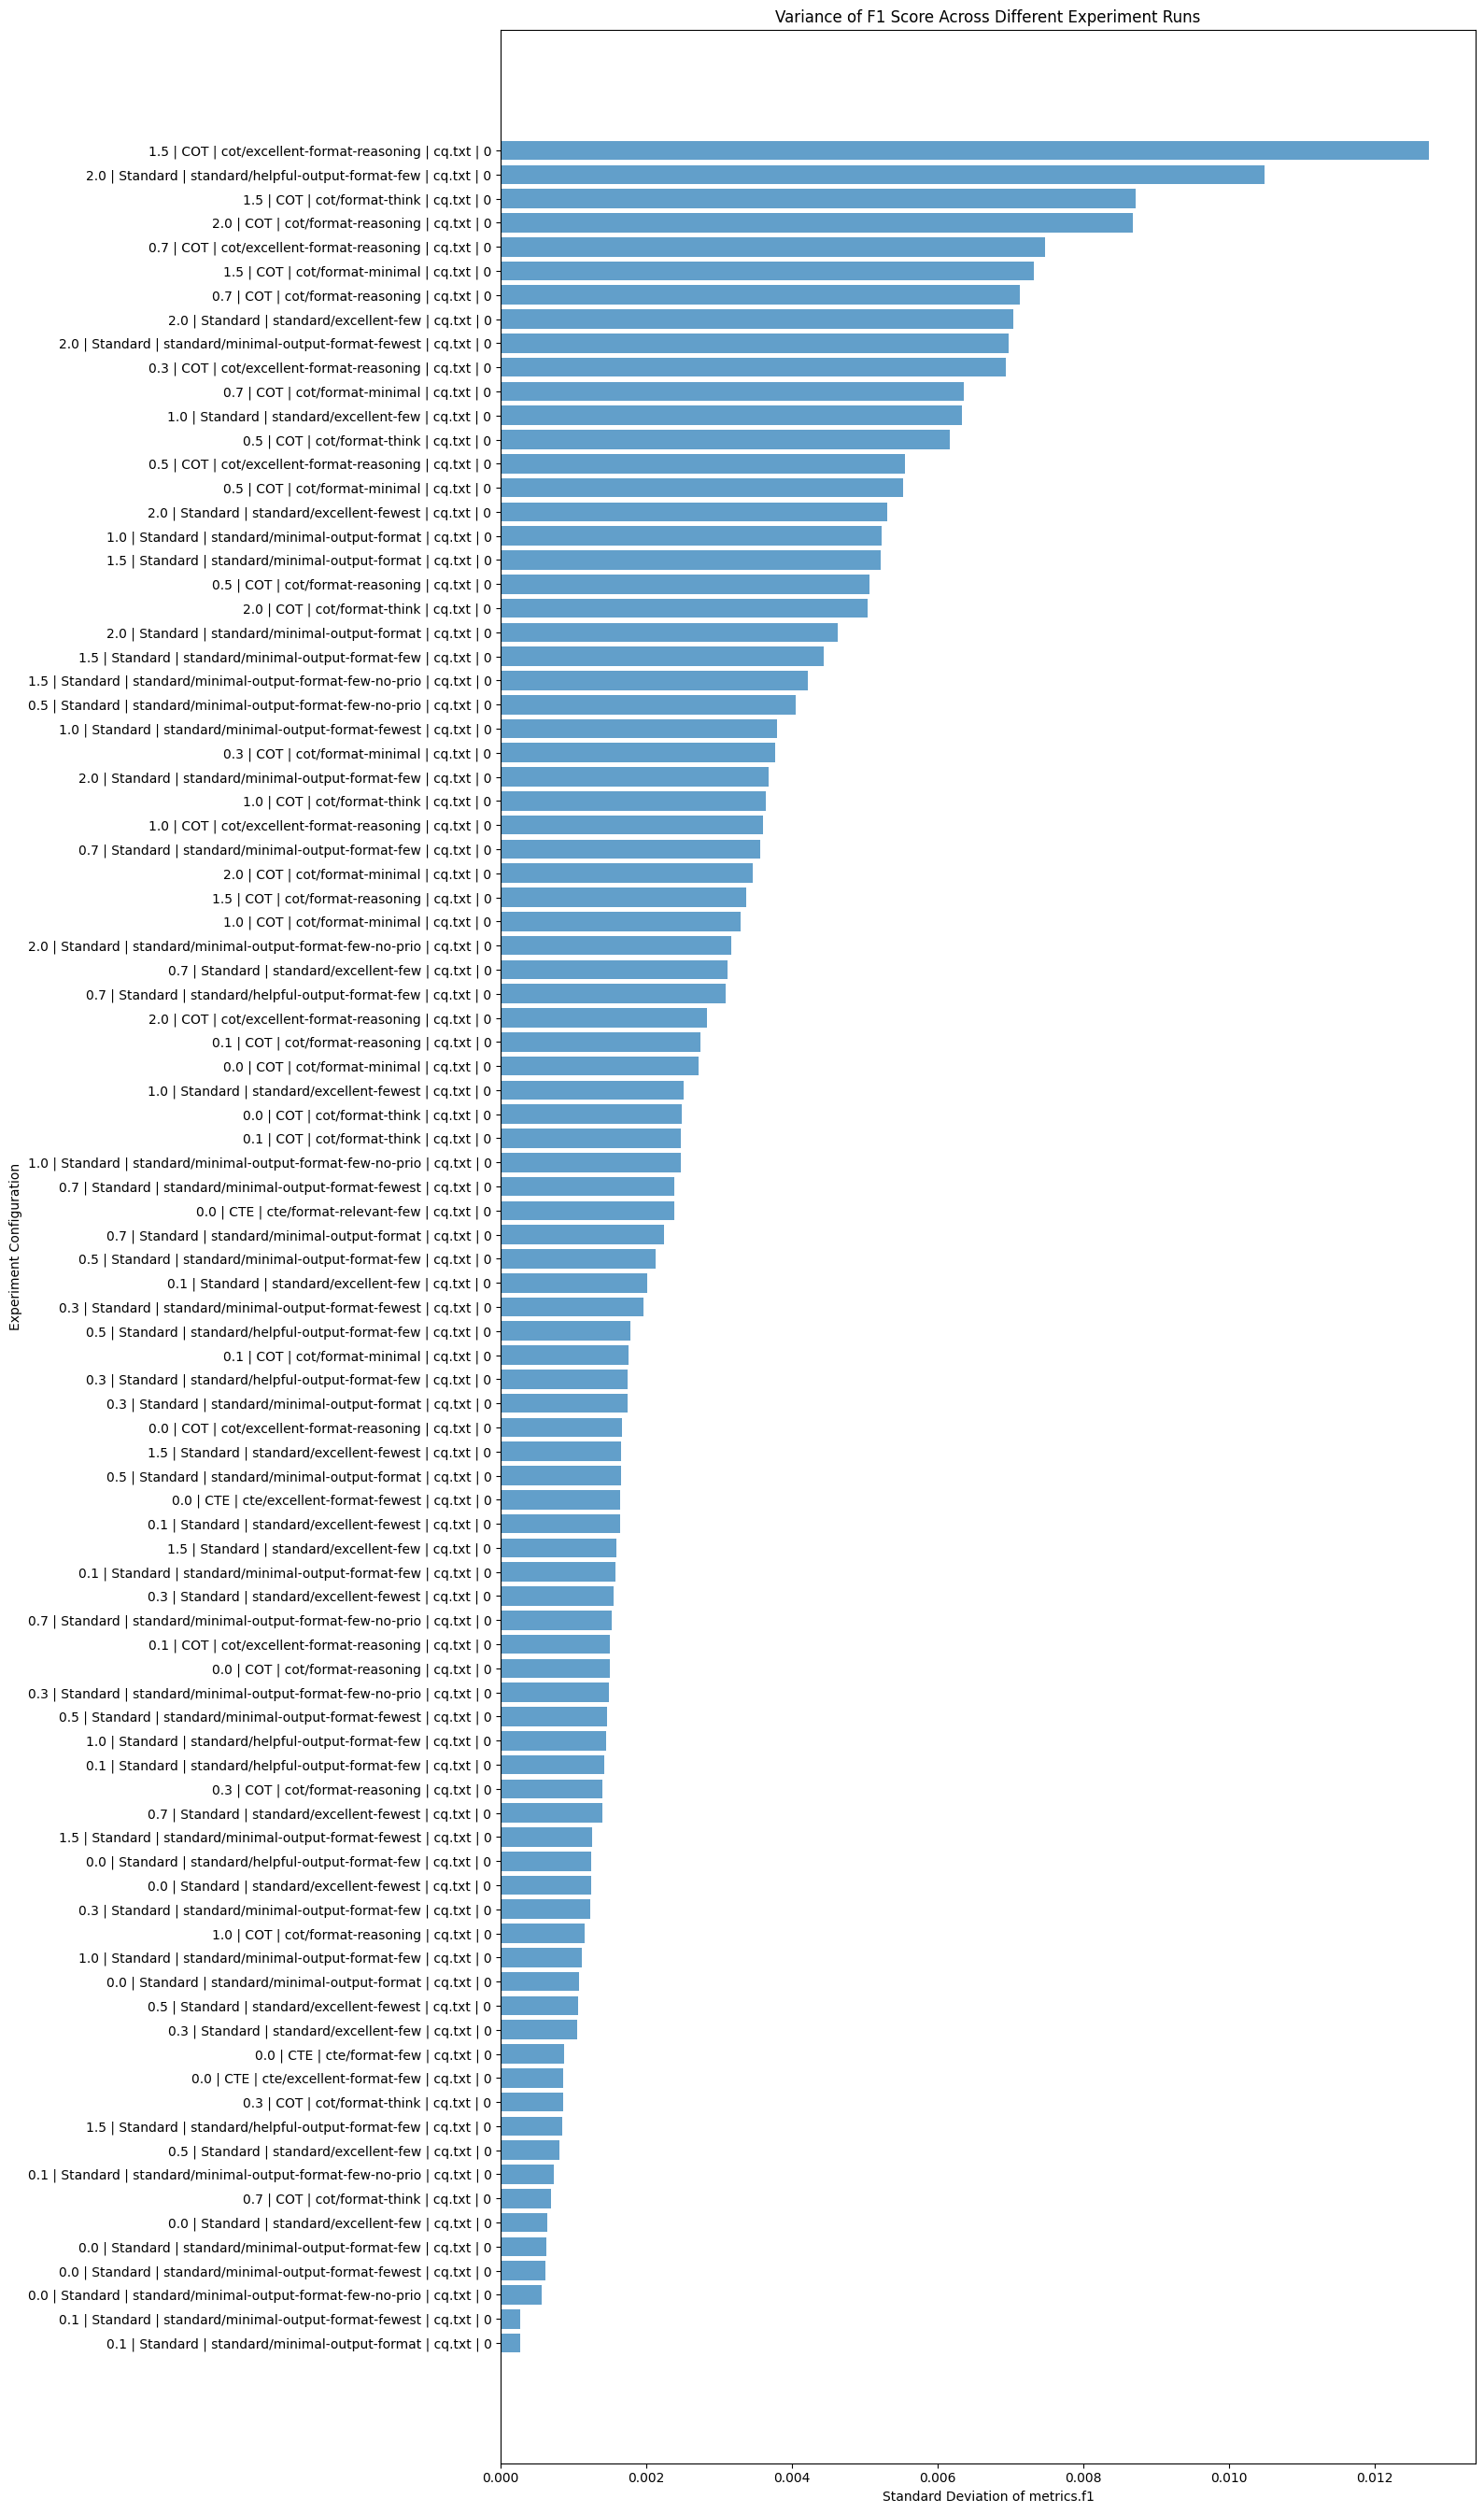

In [40]:
# Filter out experiments with F1 score < 0.1
_df = df[df['metrics.f1'] >= 0.1]
plot_variance(_df, 'metrics.f1')

In [41]:
df_target = df_avg.copy()
df_target.sort_values('metrics.f1', inplace=True, ascending=False)
df_target

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
34,CTE,cte/format-few,cq.txt,0,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
35,CTE,cte/format-relevant-few,cq.txt,0,0.0,0.586471,0.700384,0.624601,0.732972,0.582895,0.713123,0.475309,0.575736
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
55,Standard,standard/helpful-output-format-few,cq.txt,0,0.5,0.575231,0.699279,0.623536,0.741159,0.550000,0.701286,0.473251,0.566047
77,Standard,standard/minimal-output-format-few,cq.txt,0,0.1,0.573438,0.699174,0.620075,0.736587,0.550000,0.705866,0.473251,0.570958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Standard,standard/minimal,cq.txt,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61,Standard,standard/minimal,cq.txt,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,Standard,standard/minimal,cq.txt,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
63,Standard,standard/minimal,cq.txt,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
def plot_metric(dataf, metric, *, ax, title, bar_width, ylabel=None):
    prompts = [
        f"{method}/{sp}/{up}/{fs}"
        for method, sp, up, fs in zip(
            dataf["params.qa.technique"].values,
            dataf["params.qa.system_prompt"].values,
            dataf["params.qa.user_prompt_template"].values,
            dataf["params.qa.n_shot"].values,
        )
    ]
    x = np.arange(len(prompts))
    metrics = {
        "2hops": dataf[f"metrics.2hops.{metric}"].values,
        "3hops": dataf[f"metrics.3hops.{metric}"].values,
        "4hops": dataf[f"metrics.4hops.{metric}"].values,
        "all": dataf[f"metrics.{metric}"].values,
    }
    bars_2hops = ax.bar(x - bar_width, metrics["2hops"], bar_width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], bar_width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + bar_width, metrics["4hops"], bar_width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=90)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)

def plot_dataframe(dataf, bar_width=0.3):
    # Creating subplots for Exact Match and F1, separating them for clarity
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18), sharey=True)

    dataf = dataf.sort_values("metrics.f1")

    # Plotting Exact Match
    plot_metric(dataf, 'exact_match', ax=ax1, title="EM", bar_width=bar_width, ylabel="Score")

    # Plotting F1
    plot_metric(dataf, 'f1', ax=ax2, title="F1", bar_width=bar_width, ylabel="Score")

    # Creating a shared legend outside the plots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.tight_layout()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1
34,CTE,cte/format-few,cq.txt,0,0.0,0.585161,0.701464,0.621140,0.737310
35,CTE,cte/format-relevant-few,cq.txt,0,0.0,0.586471,0.700384,0.624601,0.732972
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.574266,0.699507,0.620075,0.736807
55,Standard,standard/helpful-output-format-few,cq.txt,0,0.5,0.575231,0.699279,0.623536,0.741159
77,Standard,standard/minimal-output-format-few,cq.txt,0,0.1,0.573438,0.699174,0.620075,0.736587
79,Standard,standard/minimal-output-format-few,cq.txt,0,0.5,0.569577,0.698019,0.615282,0.736090
56,Standard,standard/helpful-output-format-few,cq.txt,0,0.7,0.569852,0.697783,0.615815,0.737830
52,Standard,standard/helpful-output-format-few,cq.txt,0,0.0,0.574266,0.697462,0.619542,0.737365
78,Standard,standard/minimal-output-format-few,cq.txt,0,0.3,0.570266,0.696969,0.619542,0.737613
54,Standard,standard/helpful-output-format-few,cq.txt,0,0.3,0.573162,0.696939,0.617412,0.735700


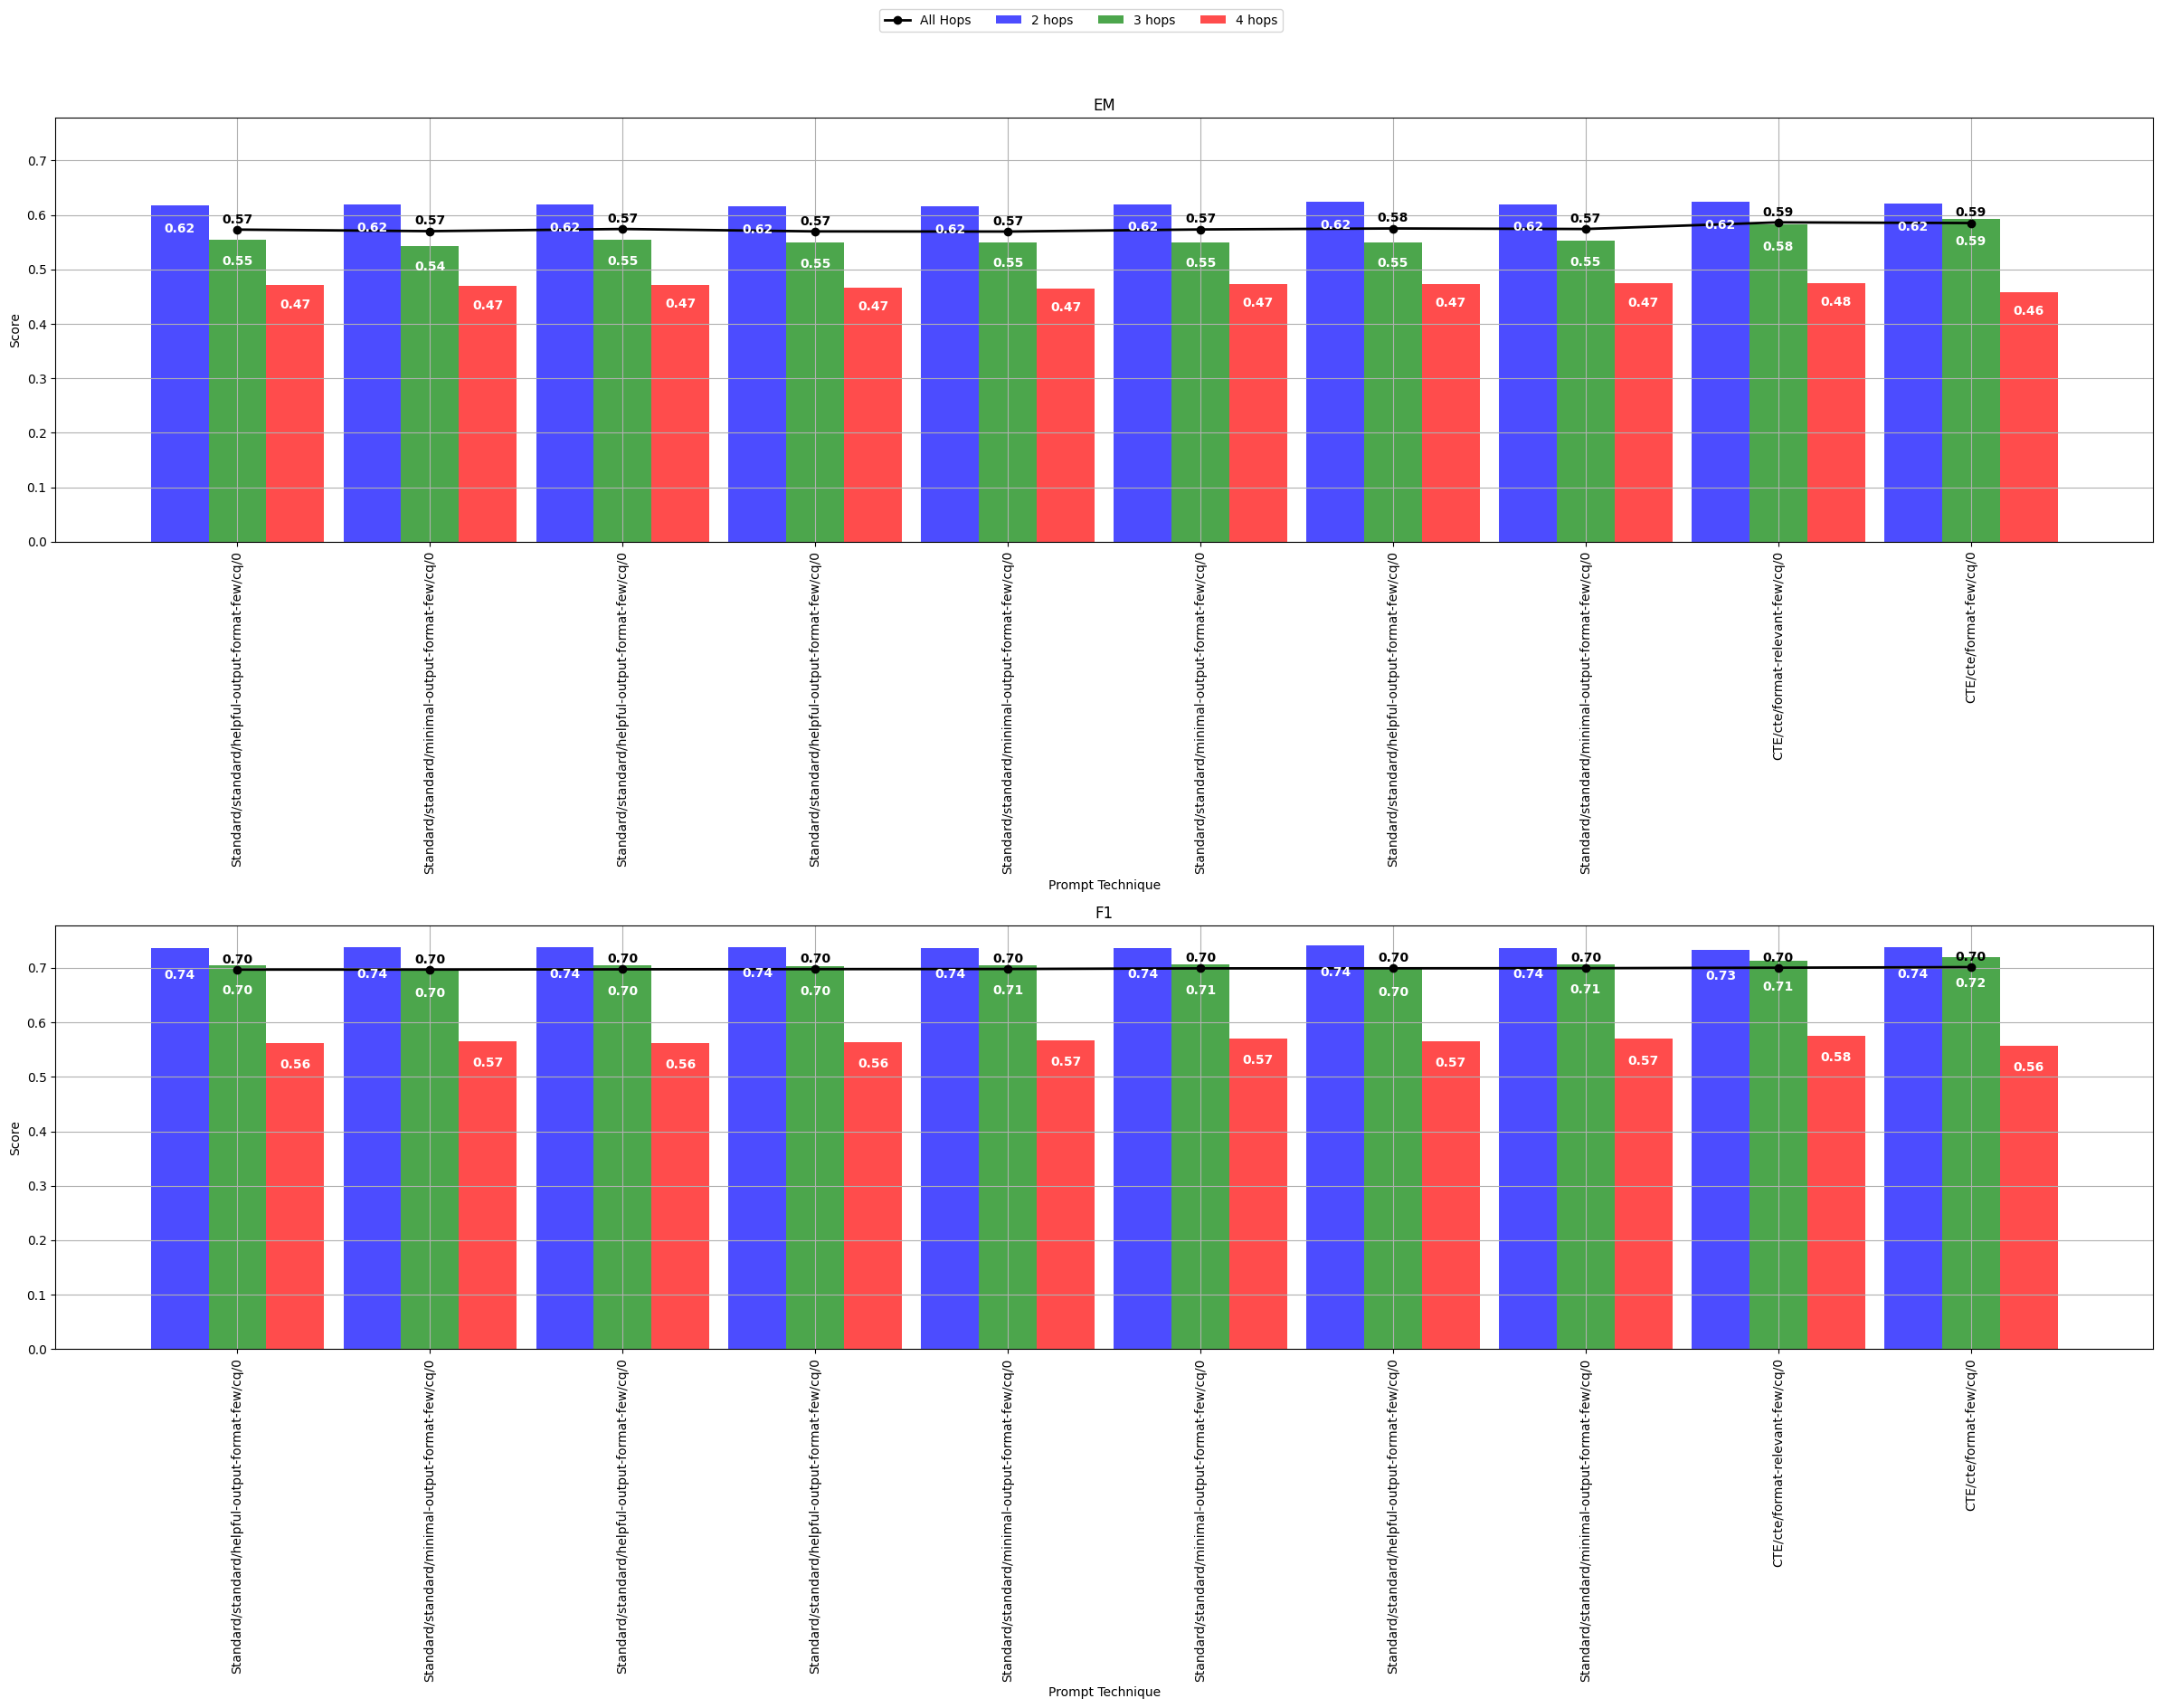

In [43]:
_df = df_target.sort_values('metrics.f1').iloc[-10:]
plot_dataframe(_df)
_df.loc[::-1, target_param_cols + metric_cols[:4]]

In [44]:
mask = df_target.groupby("params.qa.technique")["metrics.f1"].idxmax()
df_target.loc[mask].sort_values("metrics.f1", ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
34,CTE,cte/format-few,cq.txt,0,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
8,COT,cot/format-minimal,cq.txt,0,0.0,0.553855,0.667542,0.604899,0.719454,0.527632,0.652391,0.445267,0.535496


,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
34,CTE,cte/format-few,cq.txt,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
35,CTE,cte/format-relevant-few,cq.txt,0.0,0.586471,0.700384,0.624601,0.732972,0.582895,0.713123,0.475309,0.575736
76,Standard,standard/minimal-output-format-few,cq.txt,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
55,Standard,standard/helpful-output-format-few,cq.txt,0.5,0.575231,0.699279,0.623536,0.741159,0.550000,0.701286,0.473251,0.566047
77,Standard,standard/minimal-output-format-few,cq.txt,0.1,0.573438,0.699174,0.620075,0.736587,0.550000,0.705866,0.473251,0.570958
...,...,...,...,...,...,...,...,...,...,...,...,...
60,Standard,standard/minimal,cq.txt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61,Standard,standard/minimal,cq.txt,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,Standard,standard/minimal,cq.txt,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
63,Standard,standard/minimal,cq.txt,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


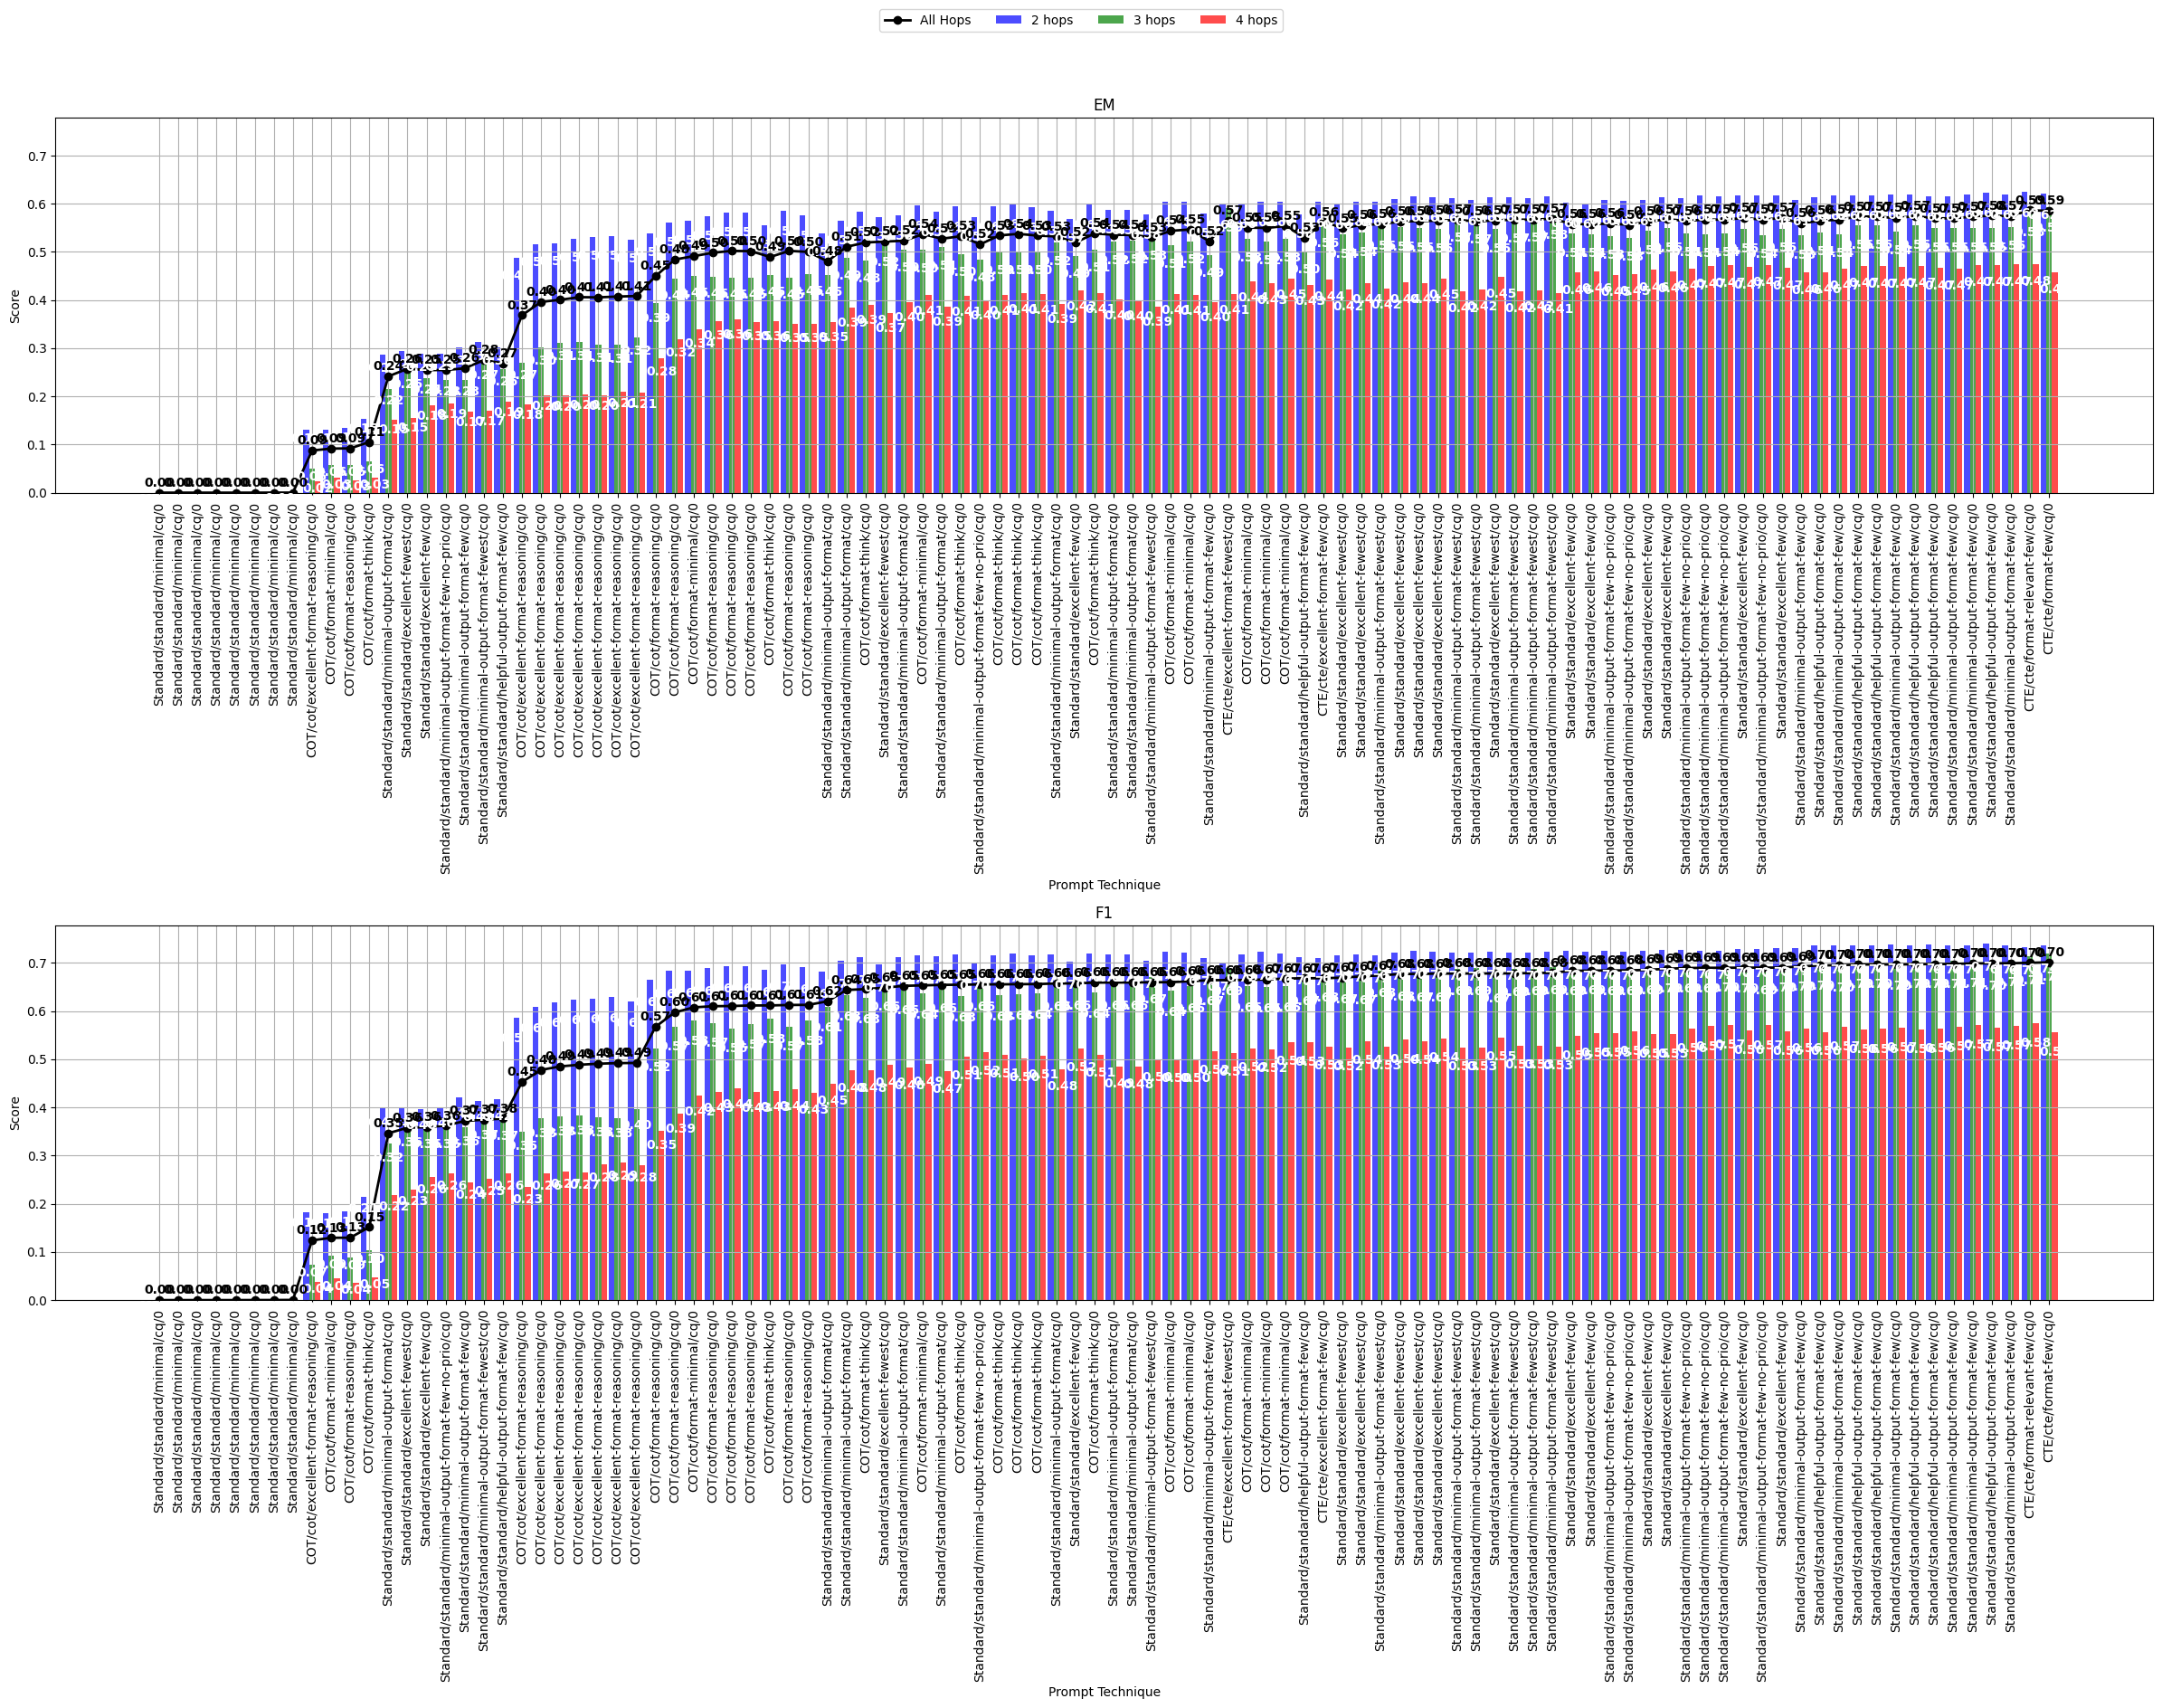

In [45]:
mask = df_target['params.qa.n_shot'] == 0
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False).drop(columns=['params.qa.n_shot'])

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
76,Standard,standard/minimal-output-format-few,cq.txt,0,0.0,0.574266,0.699507,0.620075,0.736807,0.552193,0.707299,0.474074,0.569578
55,Standard,standard/helpful-output-format-few,cq.txt,0,0.5,0.575231,0.699279,0.623536,0.741159,0.550000,0.701286,0.473251,0.566047
77,Standard,standard/minimal-output-format-few,cq.txt,0,0.1,0.573438,0.699174,0.620075,0.736587,0.550000,0.705866,0.473251,0.570958
79,Standard,standard/minimal-output-format-few,cq.txt,0,0.5,0.569577,0.698019,0.615282,0.736090,0.550000,0.705085,0.465021,0.567069
56,Standard,standard/helpful-output-format-few,cq.txt,0,0.7,0.569852,0.697783,0.615815,0.737830,0.549123,0.703599,0.466667,0.563067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,Standard,standard/minimal,cq.txt,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61,Standard,standard/minimal,cq.txt,0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
62,Standard,standard/minimal,cq.txt,0,0.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
63,Standard,standard/minimal,cq.txt,0,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


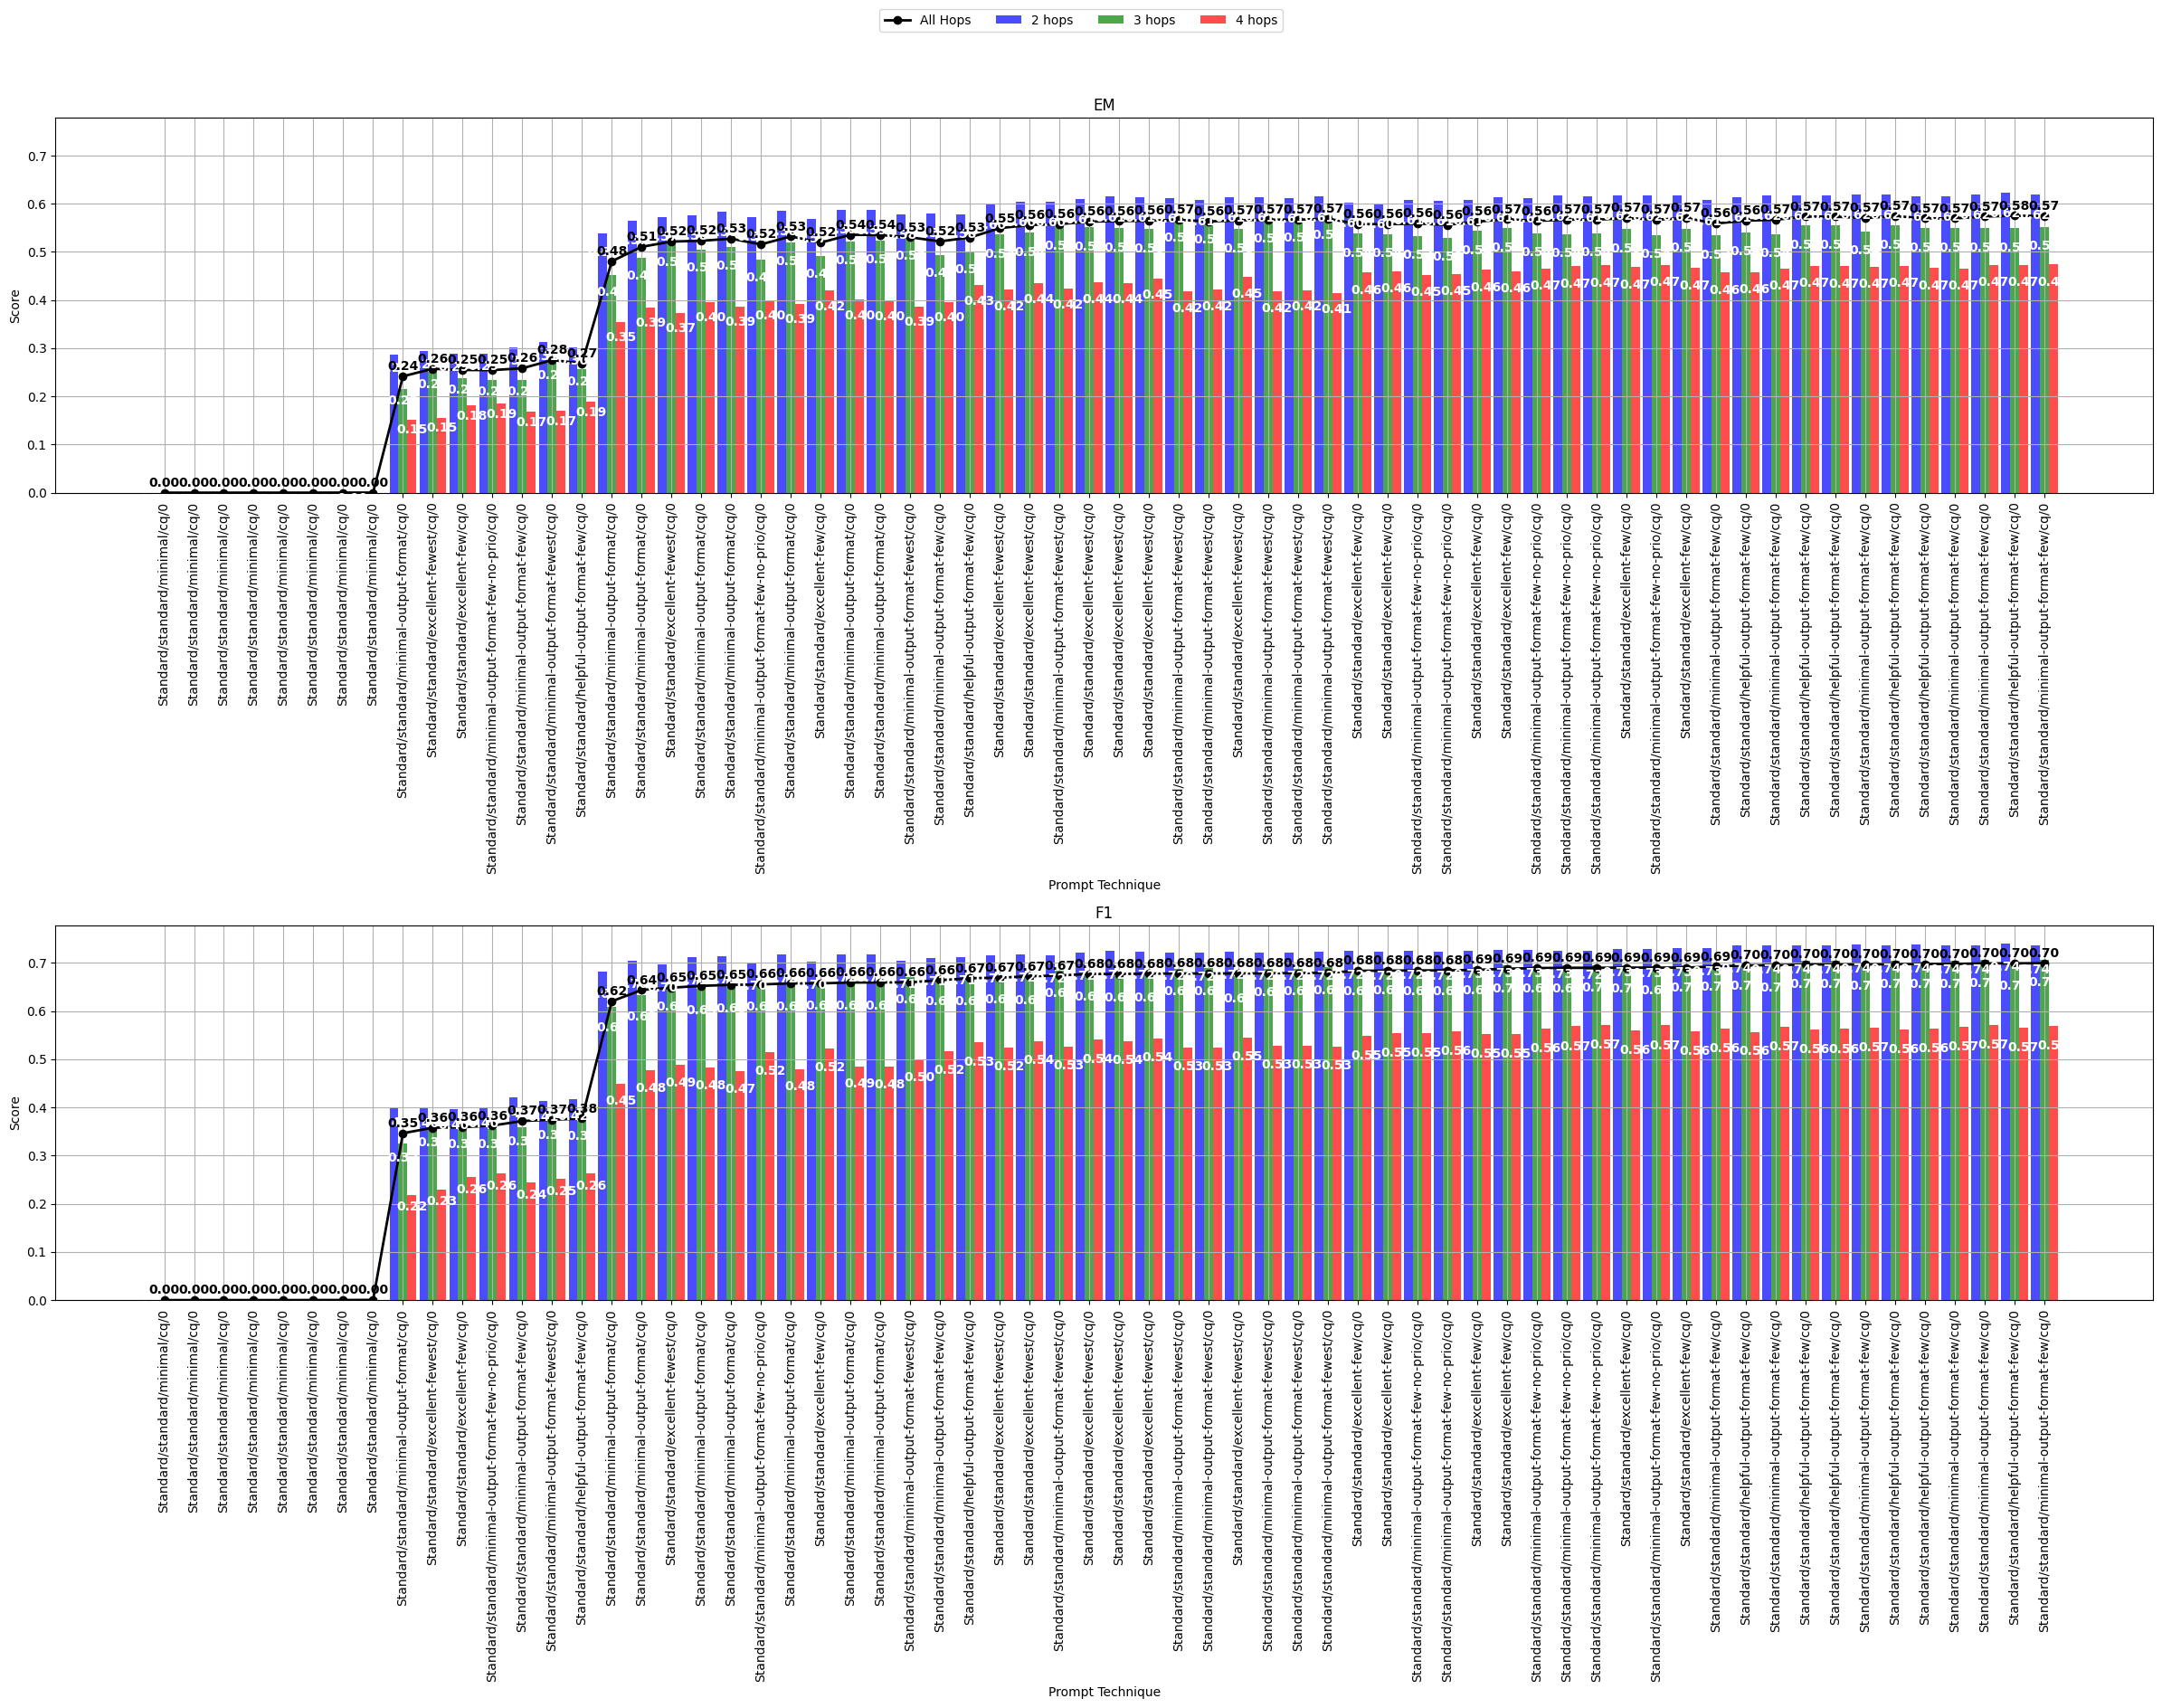

In [46]:
mask = df_target['params.qa.technique'] == 'Standard'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
34,CTE,cte/format-few,cq.txt,0,0.0,0.585161,0.701464,0.621140,0.737310,0.593421,0.719570,0.458436,0.556677
35,CTE,cte/format-relevant-few,cq.txt,0,0.0,0.586471,0.700384,0.624601,0.732972,0.582895,0.713123,0.475309,0.575736
32,CTE,cte/excellent-format-few,cq.txt,0,0.0,0.562405,0.668353,0.603301,0.710047,0.558772,0.675146,0.442798,0.526716
33,CTE,cte/excellent-format-fewest,cq.txt,0,0.0,0.565301,0.664472,0.598509,0.698741,0.591667,0.689195,0.413169,0.512140


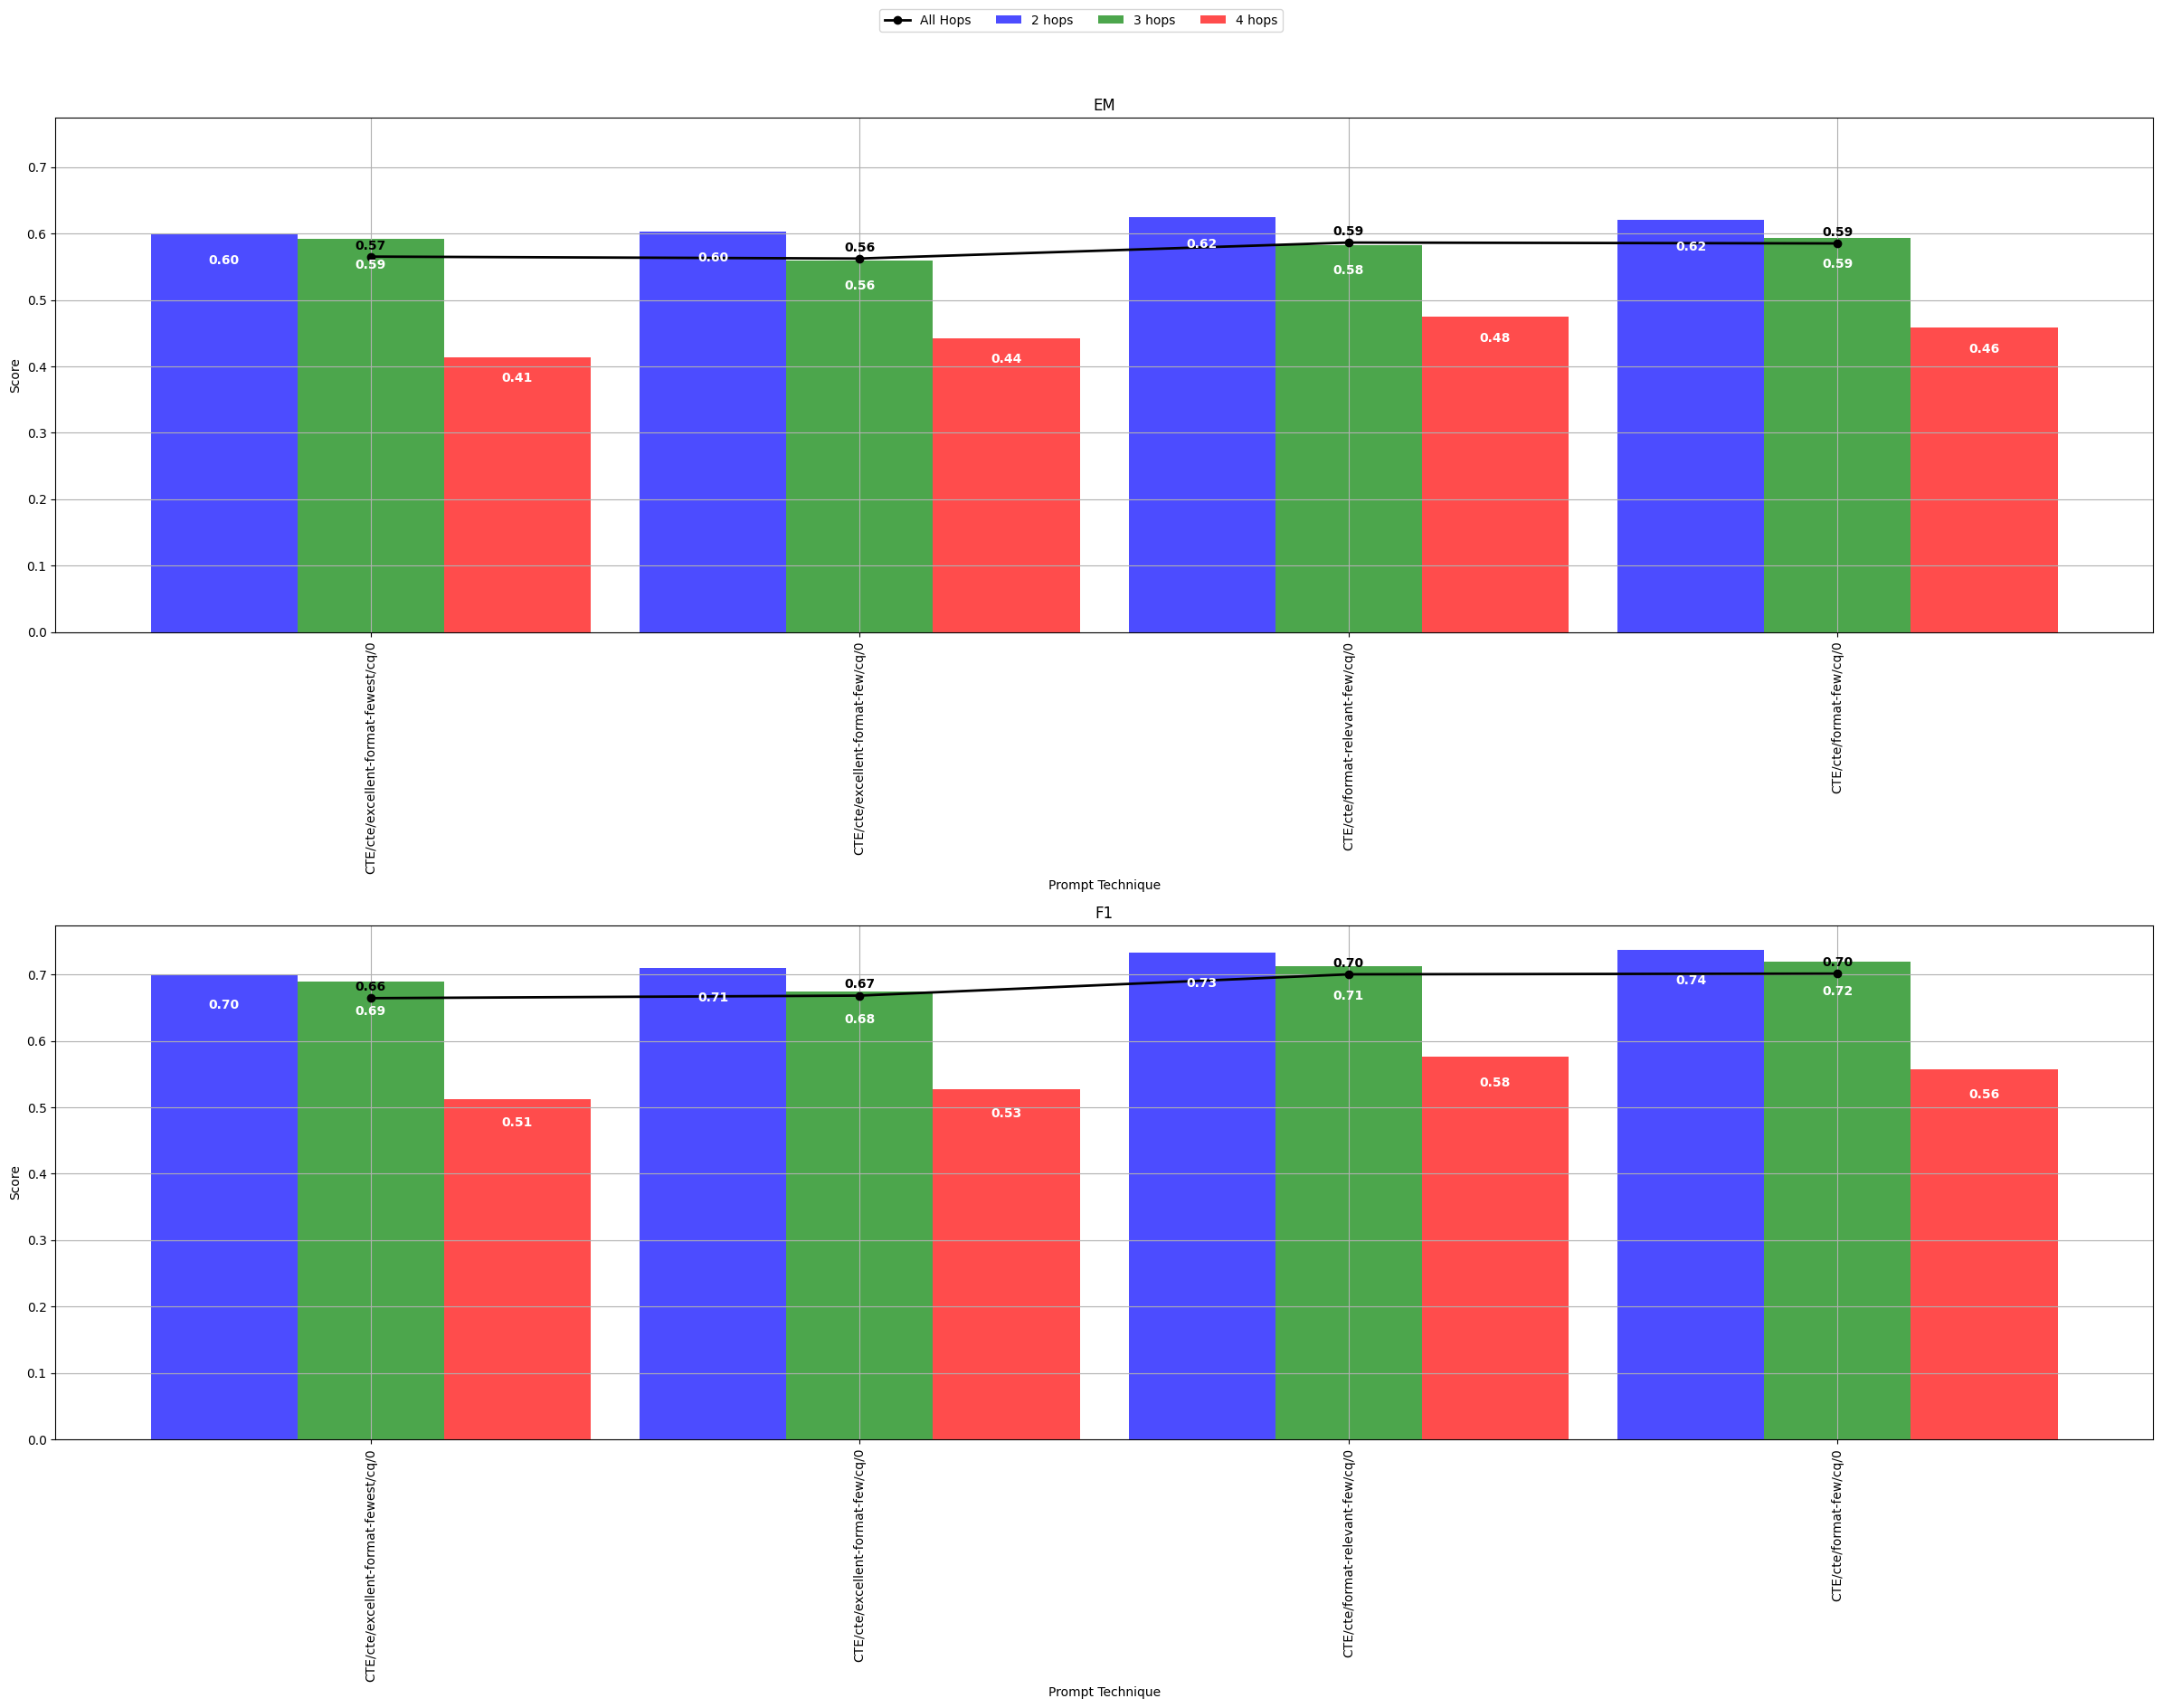

In [47]:
mask = df_target['params.qa.technique'] == 'CTE'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.n_shot,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
8,COT,cot/format-minimal,cq.txt,0,0.0,0.553855,0.667542,0.604899,0.719454,0.527632,0.652391,0.445267,0.535496
12,COT,cot/format-minimal,cq.txt,0,0.7,0.549579,0.665909,0.603834,0.722626,0.521491,0.650191,0.434568,0.520071
9,COT,cot/format-minimal,cq.txt,0,0.1,0.550545,0.664687,0.601171,0.717966,0.526316,0.652606,0.439506,0.522651
11,COT,cot/format-minimal,cq.txt,0,0.5,0.546545,0.662148,0.604899,0.721064,0.522368,0.651842,0.411523,0.499359
10,COT,cot/format-minimal,cq.txt,0,0.3,0.543787,0.660145,0.604100,0.723095,0.514035,0.642496,0.413169,0.498661
27,COT,cot/format-think,cq.txt,0,0.5,0.538408,0.659261,0.598509,0.720166,0.505263,0.638708,0.414815,0.509550
26,COT,cot/format-think,cq.txt,0,0.3,0.533857,0.656207,0.593184,0.715728,0.500439,0.637942,0.413169,0.506481
28,COT,cot/format-think,cq.txt,0,0.7,0.537443,0.655986,0.599840,0.719087,0.500000,0.634702,0.414815,0.500860
24,COT,cot/format-think,cq.txt,0,0.0,0.534133,0.655633,0.595048,0.716456,0.500000,0.633874,0.409877,0.508437
25,COT,cot/format-think,cq.txt,0,0.1,0.532616,0.654867,0.595048,0.717617,0.496053,0.631162,0.408230,0.505368


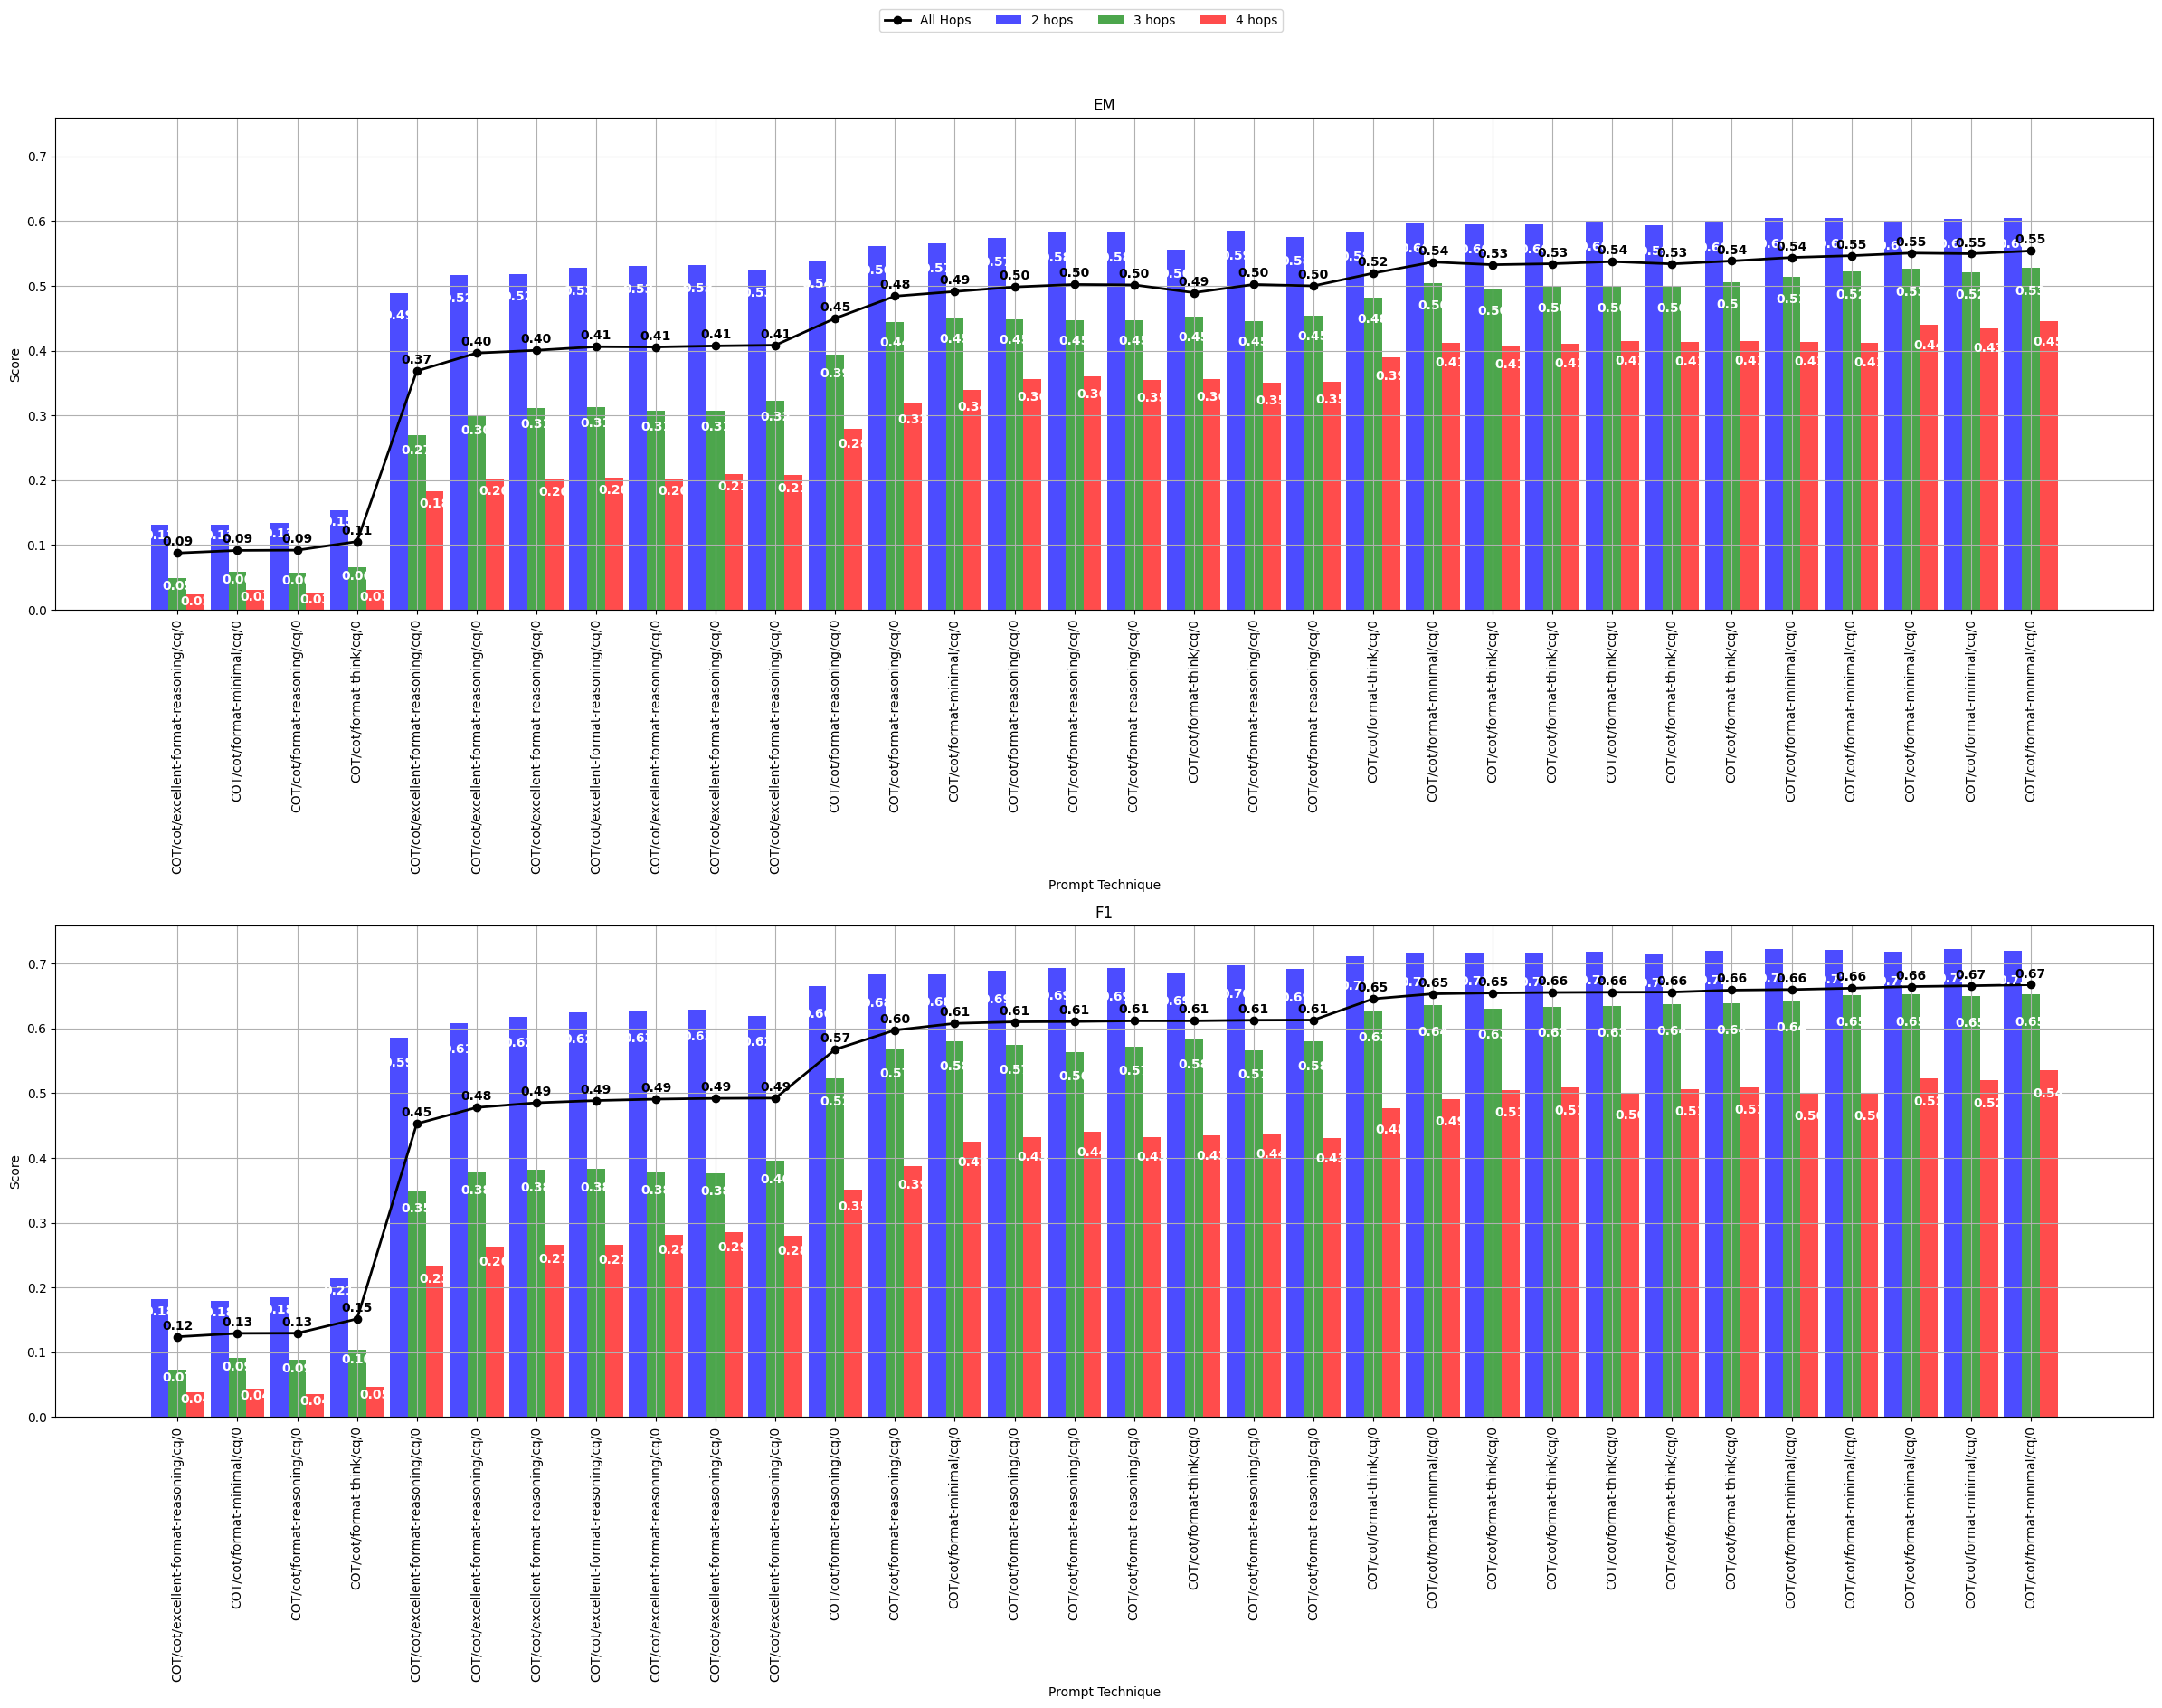

In [48]:
mask = df_target['params.qa.technique'] == 'COT'
plot_dataframe(df_target.loc[mask])
df_target.loc[mask].sort_values('metrics.f1', ascending=False)